# Intro

The objective of this notebook is:
- to do the initial data exploration, 
- id missing data, format data types 
- and visualize patterns in churn

In [2]:
# Import sys, os
import sys
import os

# Change the root folder path
project_root = os.path.abspath("..")
sys.path.append(project_root)

# Import analytical packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# load the data
customers = pd.read_csv('../data/customers.csv')
sales = pd.read_csv('../data/sales.csv')

In [4]:
# Check the first few rows of the customers data
customers.head()

,id,name,last_name,email,registration_date,birth_date,street_address,city,state,prefered_device,email_opt_in,prefered_payment_methods,gender
0,21bade02-6a6a-4768-b2ed-66ffdcc99396,Anthony,Myers,joshua87@example.org,2023-10-11,1966-03-10,02822 Martinez Stravenue Apt. 937,West Matthewmouth,North Dakota,Tablet,False,Apple Pay,female
1,4e9a430c-bcfd-456a-9221-62b36754614c,Kristin,Cooper,fadams@example.net,2023-12-07,1966-09-22,7411 Serrano Shores,Kennedyfort,Connecticut,Desktop,False,Apple Pay,female
2,5d6e1742-3f88-43ea-9f30-a0ea38b376e4,Jennifer,Rice,browningpatricia@example.org,2022-05-19,1979-01-13,869 Laura Glen,Tuckerborough,Minnesota,Mobile,False,Apple Pay,male
3,a33bff68-6104-44bf-af0e-5a598144c696,Daniel,Washington,stevenbarrett@example.org,2022-05-15,1965-12-28,20872 Jeffrey Land,West Cristian,New Jersey,Mobile,True,Credit Card,male
4,188112f8-5a25-408f-b7b4-b7dfb1bed0c3,Mary,Lopez,devinjones@example.org,2022-07-30,1959-12-13,46382 Mary Plain Suite 627,Port Danielbury,North Carolina,Tablet,True,Credit Card,female


In [5]:
# Check information of the customers data
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        10000 non-null  object
 1   name                      10000 non-null  object
 2   last_name                 10000 non-null  object
 3   email                     10000 non-null  object
 4   registration_date         10000 non-null  object
 5   birth_date                9521 non-null   object
 6   street_address            10000 non-null  object
 7   city                      10000 non-null  object
 8   state                     9484 non-null   object
 9   prefered_device           9044 non-null   object
 10  email_opt_in              10000 non-null  bool  
 11  prefered_payment_methods  10000 non-null  object
 12  gender                    10000 non-null  object
dtypes: bool(1), object(12)
memory usage: 947.4+ KB


In [6]:
# Check missing data
customers.isnull().mean()*100

id                          0.00
name                        0.00
last_name                   0.00
email                       0.00
registration_date           0.00
birth_date                  4.79
street_address              0.00
city                        0.00
state                       5.16
prefered_device             9.56
email_opt_in                0.00
prefered_payment_methods    0.00
gender                      0.00
dtype: float64

# Handling Missing Data

There are various ways to handle missing data.

We can see that the there are basically two types of missing data in our `customers` dataset:

- Categorical data:
    - `state`
    - `prefered_device`
- Ordinal categorical data:
    - `birth_date`

The appropriate technique for handling missing data varies depending on the data type, the potential reasons behind the missingness, and other relevant factors.

It is generally recommended to flag identify missing values before deciding whether to impute them, drop them (complete case analysis), or use another strategy.

In [7]:
# Capture the columns with missing data in a list
missing_cols = customers.columns[customers.isnull().mean() > 0].tolist()

In [8]:
# Flag the missing data on the customers data
customers['state_missing'] = customers['state'].isnull()
customers['prefered_device_missing'] = customers['prefered_device'].isnull()
customers['birth_date_missing'] = customers['birth_date'].isnull()

In [9]:
# Check the new columns where the data is missing
customers[['id', 'name', 'state', 'state_missing', 
           'prefered_device', 'prefered_device_missing', 
           'birth_date', 'birth_date_missing']][
    customers[['id', 'name', 'state', 'state_missing', 
               'prefered_device', 'prefered_device_missing', 
               'birth_date', 'birth_date_missing']].isnull().any(axis=1)
].head()

,id,name,state,state_missing,prefered_device,prefered_device_missing,birth_date,birth_date_missing
17,1afb5484-5e62-44ae-853e-258e79f50b2a,Kayla,Texas,False,Desktop,False,NaN,True
29,7c82a5cb-0e5d-4ccd-a201-f7d138d3c30e,Gerald,Nevada,False,NaN,True,1977-06-18,False
31,7d7b2fa1-20b0-4245-bc96-28dd8436bacd,Melinda,Nebraska,False,Desktop,False,NaN,True
34,725b938e-3c3d-4b2f-be42-36cced51912a,Randy,North Dakota,False,NaN,True,1963-05-02,False
35,3f9b17d1-7233-4e58-ad8f-652430cecc95,Pamela,NaN,True,NaN,True,NaN,True


The flagging worked as intended, now let's proceed to the missing data imputation

## Missing Data Imputation

When imputing missing data, it's very important to consider the underlying data distribution. 

Imputation methods should ideally preserve the statistical properties of the original data, like  mean, variance, and overall shape. 

If we significantly alter the distribution, we can introduce bias and distort the results of subsequent analysis. 

In [15]:
missing_cols

['birth_date', 'state', 'prefered_device']

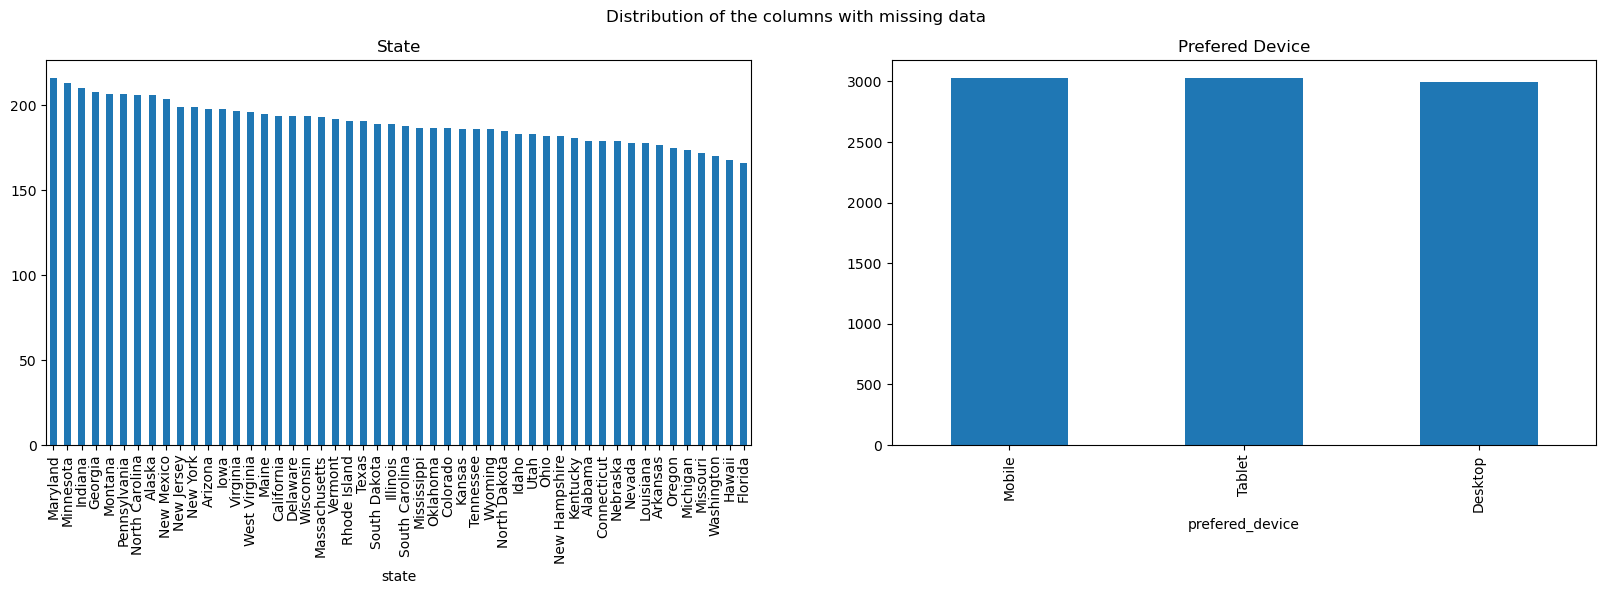

In [13]:
# Plot the distribution of the columns with missing data, except birth date
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
customers['state'].value_counts(dropna=True).plot(kind='bar', ax=ax[0])
ax[0].set_title('State')
customers['prefered_device'].value_counts(dropna=True).plot(kind='bar', ax=ax[1])
ax[1].set_title('Prefered Device')

# Add a title to the figure
fig.suptitle('Distribution of the columns with missing data')

plt.show()

This distribution in the data is a consequence of the data generation process, I'll change the distributions to get something a little more realistic.

